In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from scipy.signal import convolve2d
from scipy.signal import convolve
import copy
import json
import time as tm
from numba import jit, prange

In [2]:
"""
Changeable parameters
"""
filepath = 'cosmo_test_300125_numba'

n_strains = 2
n_nutrients = 2

#The dependencies of strain the strains on each nutrient. Within each strain and nutrient, COLUMN 1 is UPTAKE, 
#COLUMN 2 is RELEASE. 1 means they do that function, 0 means they do not
dependencies = np.zeros((n_strains,n_nutrients,2))


#This initialization is for classic CoSMO type crossfeeding.
dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,0,1] = 1 #strain 2, release nutrient 1

#include this for cheater strain 3
#dependencies[2,1,0] = 1 #strain 3, uptake nutrient 2

#include this for cheater strain 3
#dependencies[2,2,0] = 1 #strain 2, uptake nutrient 2


"""
circle for n=3

dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,2,1] = 1 #strain 2, release nutrient 3

dependencies[2,2,0] = 1 #strain 3, uptake nutrient 3
dependencies[2,0,1] = 1 #strain 2, release nutrient 1
"""


'\ncircle for n=3\n\ndependencies[0,0,0] = 1 #strain 1, uptake nutrient 1\ndependencies[0,1,1] = 1 #strain 1, release nutrient 2\n\ndependencies[1,1,0] = 1 #strain 2, uptake nutrient 2\ndependencies[1,2,1] = 1 #strain 2, release nutrient 3\n\ndependencies[2,2,0] = 1 #strain 3, uptake nutrient 3\ndependencies[2,0,1] = 1 #strain 2, release nutrient 1\n'

In [3]:
"""
general variables for diffusion
"""

side_len = 750 #microns
box_height = 300 #microns
cell_size = 5 #microns
cell_to_diff_ratio = 10
density = 10 #mm^-2

t_final = 24 #hrs
dt_cell = 0.1 #hrs
dt_diff = 1 #second
dt_cell_to_diff_ratio = 360

nsteps = int(t_final/dt_cell)
time = np.arange(nsteps)/dt_diff + dt_diff

D = 20 #um^2/s
DS = D/np.square(cell_size*cell_to_diff_ratio) #cell_side^2/s
print(DS)

0.008


In [4]:
"""
calculated quantities
"""
#the box to keep cells in
cell_sides = int(side_len/cell_size)
cell_height = int(box_height/cell_size)
X = np.zeros((cell_sides,cell_sides,cell_height))

#the boxes for each nutrient
diff_sides = int(cell_sides/cell_to_diff_ratio)
diff_height = int(cell_height/cell_to_diff_ratio)

#The blank matrix into which nutrients will go
S = np.zeros((n_nutrients,diff_sides,diff_sides,diff_height))

In [5]:
"""
nutrient initialization 
"""
#We are going to do something a little wild here. Because all of our CoSMO strains have the same genetic background
#outside of the specific mutations, we are going to assume that the effect of growth of the various nutrients on
#different strains is the same. That is, we can define how a nutrient affects cell growth and apply those same 
#rates to every other cell that depends on that nutrient. In this manner, we can write out all of the rates
#for each nutrient once and then simply apply those constraints to a cell's growth by defining its dependencies. 
#This will further allow us to flexibly modulate the various interdependencies of different cell types.

#Lys
alphaL = 5.4 #nutrient required for reproduction (fmole)
rL = 0.51 #Maximum growth rate (hr^-1)
vmL = alphaL*rL #maximum uptake rate (fmole/hr)
"""
060125 The dt for diffusion is 1 second, so to ease calculations, we will put all of the parameters that are 
updated at the same time as diffusion in terms of seconds.
"""
vmL_s = vmL/(60^2) #maximum uptake rate (fmole/s)
KL = 2.1e6 #Monod constant (fmole/ml)
gammaL = 0.4 #release rate (fmole/(cell*hr))
gammaL_s = gammaL/(60^2) #release rate (fmole/(cell*s))
dL = 0.021 #death rate (hr^-1)

#Ade
alphaA = 3.1
rA = 0.44
vmA = alphaA*rA
vmA_s = vmA/(60^2)
KA = 1.3e6
gammaA = 0.26
gammaA_s = gammaA/(60^2)
dA = 0.015 #death rate (hr^-1). Should this be an order of magnitude higher?


alphas = [alphaL,alphaA]
vm_list = [vmL,vmA]
gamma_list = [gammaL,gammaA]
km_list = [KL,KA]
d = [dL,dA]
r = [rL,rA]

In [6]:
def draw_config_conc(X,S,n_nutrients,title):
    
    plt_number = 0
    
    fig, ax = plt.subplots(1,n_nutrients + 1,figsize=(50,25))
    fig.suptitle(title,fontsize=75)
    ax[plt_number].imshow(X[:,:,0], cmap='hot')
    ax[plt_number].set_title('strain identities XY',fontsize=50)
    ax[plt_number].axis('off')
    
    for nn in range(n_nutrients):
        
        indicator = nn+1
        
        plt_number += 1
        
        #print(np.unique(nutrients['%s'%nn]['S_internal'][:,:,0]))
        
        ax[plt_number].imshow(S[nn,:,:,0], cmap='Greys')
        ax[plt_number].set_title('external nutrient %s'%indicator,fontsize=50)
        ax[plt_number].axis('off')
    plt.show()

In [7]:
def sum_collapse_array(M,n):
    
    #from ChatGPT
    """
    Reduces a 3D tensor M by computing the sum of points in non-overlapping n x n x n blocks.
    
    Parameters:
        M (np.ndarray): The input 3D array.
        n (int): The size of the blocks used for density calculation.
        
    Returns:
        np.ndarray: The resulting 3D tensor P containing densities of each n x n x n block.
    """
    # Ensure M is a numpy array
    M = np.asarray(M)
    d1, d2, d3 = M.shape
    
    # Check if M dimensions are divisible by n
    if d1 % n != 0 or d2 % n != 0 or d3 % n != 0:
        raise ValueError("All dimensions of the tensor must be divisible by the block size n.")
    
    # Reshape M into a 6D array where each block is n x n x n
    reshaped = M.reshape(d1 // n, n, d2 // n, n, d3 // n, n)
    
    # Calculate density for each block
    #I'm not actually calculationg densities, instead I just want the sum of the number of a given strain
    densities = np.sum(reshaped != 0, axis=(1, 3, 5))# / (n * n * n)
    
    return densities

In [8]:
def convolution_laplacian_3D(M):
    #Make a big matrix to incorporate boundary conditions
    #for this implementation, we will have periodic conditions in x and y and no flux in Z.
    #This involves literally just adding rows such that the boundary conditions are satisfied.
    #For periodic, the padded layer will be the value from the opposite side of the matrix,
    #for no flux, the padded layer (-1) equals the (1) layer such that the central difference around (0) is 0
    shp = np.shape(M)
    
    #make the padded matrix
    M_padded = np.zeros((shp[0]+2,shp[1]+2,shp[2]+2))
    
    #put the original matrix inside
    M_padded[1:-1,1:-1,1:-1] = M.copy()
    
    #pad the edges, starting with Z
    M_padded[:,:,0] = M_padded[:,:,2]
    M_padded[:,:,-1] = M_padded[:,:,-3]
    
    #pad the edges, X direction
    M_padded[0,:,:] = M_padded[-2,:,:]
    M_padded[-1,:,:] = M_padded[1,:,:]
    
    #pad the edges, Y direction
    M_padded[:,0,:] = M_padded[:,-2,:]
    M_padded[:,-1,:] = M_padded[:,1,:]
    
    """
    """
    #using the 27 point stencil
    #k = 1/26*[[[2,3,2],[3,6,3],[2,3,2]],[[3,6,3],[6,-88,6],[3,6,3]],[[2,3,2],[3,6,3],[2,3,2]]]
    
    #7 point stencil
    k = [[[0,0,0],[0,1,0],[0,0,0]],[[0,1,0],[1,-6,1],[0,1,0]],[[0,0,0],[0,1,0],[0,0,0]]]
    """
    """
    
    L = convolve(M_padded, k)
    M_upd = L[2:-2,2:-2,2:-2]
    
    #L = convolve(M_padded, k, mode='same')
    #M_upd = L[1:-1,1:-1,1:-1]
    
    return M_upd

In [9]:
class Cell:
    """Hold the properties and variables for strains."""
    def __init__(self,
                 x: int,
                 y: int,
                 z: int,
                 dependencies: np.ndarray,
                 d: float,
                 r: float,
                 n_nutrients: int,
                 alphas: list,
                 typ: int
                ):
        
        self.x = x
        self.y = y
        self.z = z
        
        self.stochastic_growth = True
        if any(dependencies[:,0]):
            self.stochastic_growth = False
        
        self.dependencies = dependencies
        self.life_flag = True
        self.quiescence_flag = False
        self.quiescence_penalty = 0.5
        self.death_rate = d
        self.reproduction_rate = r
        self.alphas = alphas
        self.typ = typ
        
        self.S_internal = [None]*n_nutrients
        #print(n_nutrients)
        #print(np.shape(self.S_internal))
        for ii in range(n_nutrients):
            #print(ii)
            #print(random.random()*alphas[ii]*dependencies[ii,0])
            self.S_internal[ii] = np.random.rand()*alphas[ii]*dependencies[ii,0]
        
    
    def process_nutrient_uptake(self,n_idx,ammnt):
        self.S_internal[n_idx] += ammnt
        return None
        
    def process_nutrient_release(self,n_idx,ammnt):
        #This will be useful later when we think about pathways, but for now it is just a placeholder
        return None
    
    def create_daughter(self, x, y, z):
        """
        Create a daughter cell at the specified position
        Should return a new Cell instance with:
        - Same dependencies and parameters as parent
        - New position (x, y, z)
        - Zero internal nutrients
        """
        daughter = Cell(x,y,z,
                        self.dependencies,
                        self.death_rate,
                        self.reproduction_rate,
                        n_nutrients,
                        [0,0],
                        self.typ
                       )
        return daughter

In [24]:

@jit(parallel=True)
def iterate_life_and_death(cells,dt,alphas,X):
    
    X_upd = np.zeros(np.shape(X))
    #loop over each cell and enumerate it's parameters
    n_cells = len(cells)
    new_cells = []*n_cells
    
    for idx in prange(n_cells):
        
        daughter = None
        
        cell = cells[idx]
        if not cell.life_flag:
            continue

        #try to kill it
        rnd = np.random.rand()
        prob_death = cell.death_rate*dt
        if rnd<prob_death:
            #print('Death')
            cell.life_flag = False
            continue



        """
        %We will now ask wether or not a given cell buds. This is not so straightforward. We want to be able to 
        accomodate a strain that requires any number of nutrients for growth. In the absence of any dependencies, we 
        will dictate that the probability of division is simply growth rate, r, times the change in time, dt. In the 
        case of nutrient dependency, we will say that a cell buds if ALL of its nutrient dependencies are filled.
        """
        if cell.quiescence_flag:
            continue
            
        #assess the requirements for budding
        budded = False
        n_requirements = 0
        n_requirements = np.sum(cell.dependencies[:,0]) #hardcoded 0 here; we only consider uptake dependencies

        #decide if budding occurred
        if n_requirements==0:

            rnd = np.random.rand()
            prob_division = cell.reproduction_rate*dt

            if rnd<prob_division:
                budded = True


        else: 

            condition_success = np.zeros(int(n_nutrients))
            
            for rr in range(n_nutrients):
                if cell.S_internal[rr] >= alphas[rr]*cell.dependencies[rr,0]:
                    condition_success[rr] = 1

            if condition_success.all():
                budded = True


        """
        Now that we have decided if something has budded let us determine where the bud goes
        """
        if budded:
            bud_coords = get_bud_location(cell,X)
            if bud_coords is not None:              
                daughter = cell.create_daughter(bud_coords[0],bud_coords[1],bud_coords[2])
                cell.S_internal = np.zeros(n_nutrients)
                
                #print(bud_coords)
                #print(cell.typ)
                
                X_upd[bud_coords[0],bud_coords[1],bud_coords[2]] = cell.typ
                
        new_cells[idx] = daughter
                                
    return new_cells, X_upd

UsageError: Line magic function `%%timeit` not found.


In [25]:
def periodic_image(coord,dimension):
    return int(coord%dimension)

In [26]:
def get_bud_location(cell,X_og):
    
    """
    The general strategy will be to generate a list of adjacent points with respect to periodic boundary 
    conditions. Then, make a smaller list of these points that are empty. If there are no empty points in the 
    plane, we will search the plane above. Once a list of potential points has been generated, the cell will 
    randomly bud into one. 
    """
    X = X_og.copy()
    
    #the coordinates of the cell to be propagated
    coords = np.array([cell.x,cell.y,cell.z])
    
    shp = np.shape(X)
    
    
    #make a 3x3 stencil to search with
    xes = np.zeros(9)
    yes = np.zeros(9)

    xes[:3] = periodic_image(coords[0] - 1,shp[0])
    xes[3:6] = periodic_image(coords[0],shp[0])
    xes[6:] = periodic_image(coords[0] + 1,shp[0])

    yes[0::3] = periodic_image(coords[1] - 1,shp[1])
    yes[1::3] = periodic_image(coords[1],shp[1])
    yes[2::3] = periodic_image(coords[1] + 1,shp[1])
    
    
    poss_xvals = xes[X[xes.astype('int'),yes.astype('int'),int(coords[2])]==0]
    poss_yvals = yes[X[xes.astype('int'),yes.astype('int'),int(coords[2])]==0]
    
    n_possibilities = np.size(poss_xvals)
    floor = 0
    
    success = True

    
    if n_possibilities == 0:
        #print('trying one floor up')
        
        new_poss_xvals = xes[X[xes.astype('int'),yes.astype('int'),int(coords[2] + 1)]==0]
        new_poss_yvals = yes[X[xes.astype('int'),yes.astype('int'),int(coords[2] + 1)]==0]

        n_new_possibilities = np.size(new_poss_xvals)
        
        if n_new_possibilities == 0:
            #print('no available space, cannot bud')
            cell.quiescence_flag = True
            success = False
        else:
            poss_xvals = new_poss_xvals
            poss_yvals = new_poss_yvals
            n_possibilities = n_new_possibilities
            floor = 1
            
    if success:
        #print('Budding!')
        index_to_bud = int(np.floor(np.random.rand()*n_possibilities))
        bud_coords = [int(poss_xvals[index_to_bud]),int(poss_yvals[index_to_bud]),int(coords[2]+floor)]
        
        return bud_coords
    
    else: 
        return None

In [27]:
def update_nutrient(S,DS,nn,cells,X,dt_diff,vm_list,km_list,gamma_list):
    
    #initialize arrays
    U = np.zeros(np.shape(S))
    Q = np.zeros(np.shape(S))
    
    for idx, cell in enumerate(cells):
        
        
        if not cell.life_flag:
            continue
        
        i, j, k = int(cell.x // cell_to_diff_ratio), int(cell.y // cell_to_diff_ratio), int(cell.z // cell_to_diff_ratio)
        
        uptake = 0
        release = 0
        
        if cell.dependencies[nn,0] and not cell.quiescence_flag:
            uptake = vm_list[nn]*S[i,j,k]/(S[i,j,k]+km_list[nn])
            cell.S_internal[nn] += uptake*dt_diff
        if cell.dependencies[nn,1] and not cell.quiescence_flag:
            release = gamma_list[nn]
        
        U[i,j,k] += uptake
        Q[i,j,k] += release

    
    S += (DS*convolution_laplacian_3D(S) - U + Q)*dt_diff
    #Note 181224: This is the very dumbest version of diffusion where it is homogeneous throughout the space.
    #This will have to be rectified in the future. 280125, maybe.
    
    return S

In [28]:
def save_data(X,S,time,dt_cell,filepath):
    
    current_timepoint = {
        
        'time' : int(time[tt]*dt_cell),
        
        'X' : X,
        
        'S' : S
        
        
    }
    
    fp = filepath + 'time_%s'%int(time[tt]*dt_cell) + 'hours'
    
    #with open('data.json', 'w') as fp:
    #    json.dump(current_timepoint, fp)

    np.save(fp,current_timepoint)

In [29]:
def initialize_population(side_len,cell_size,n_strains,density,n_nutrients,dependencies,alphas,d,X):
    
    n_cells = int(density*cell_size**2*side_len**2/1e6)
    cell_sides = side_len/cell_size
    
    #seed in a box of width side_len/4
    width = int(cell_sides/4)
    offset = int(cell_sides/2 - cell_sides/8)
    
    initial_cells = [None]*n_cells
    
    for nn in range(n_cells):
        x = int(width*np.random.rand()) + offset
        y = int(width*np.random.rand()) + offset
        z = 0 #int(width*np.random.rand())
        
        #pick which strain this position will be
        strain_identifier = int(np.floor(np.random.rand()*n_strains))
        
        X[x,y,z] = int(strain_identifier+1)
        #print(strain_identifier)
        
        initial_cells[nn] = Cell(x,y,z,
                        dependencies[strain_identifier,:,:],
                        d[strain_identifier],
                        r[strain_identifier],
                        n_nutrients,
                        alphas,
                        int(strain_identifier+1)
                       )
        
    return initial_cells, X

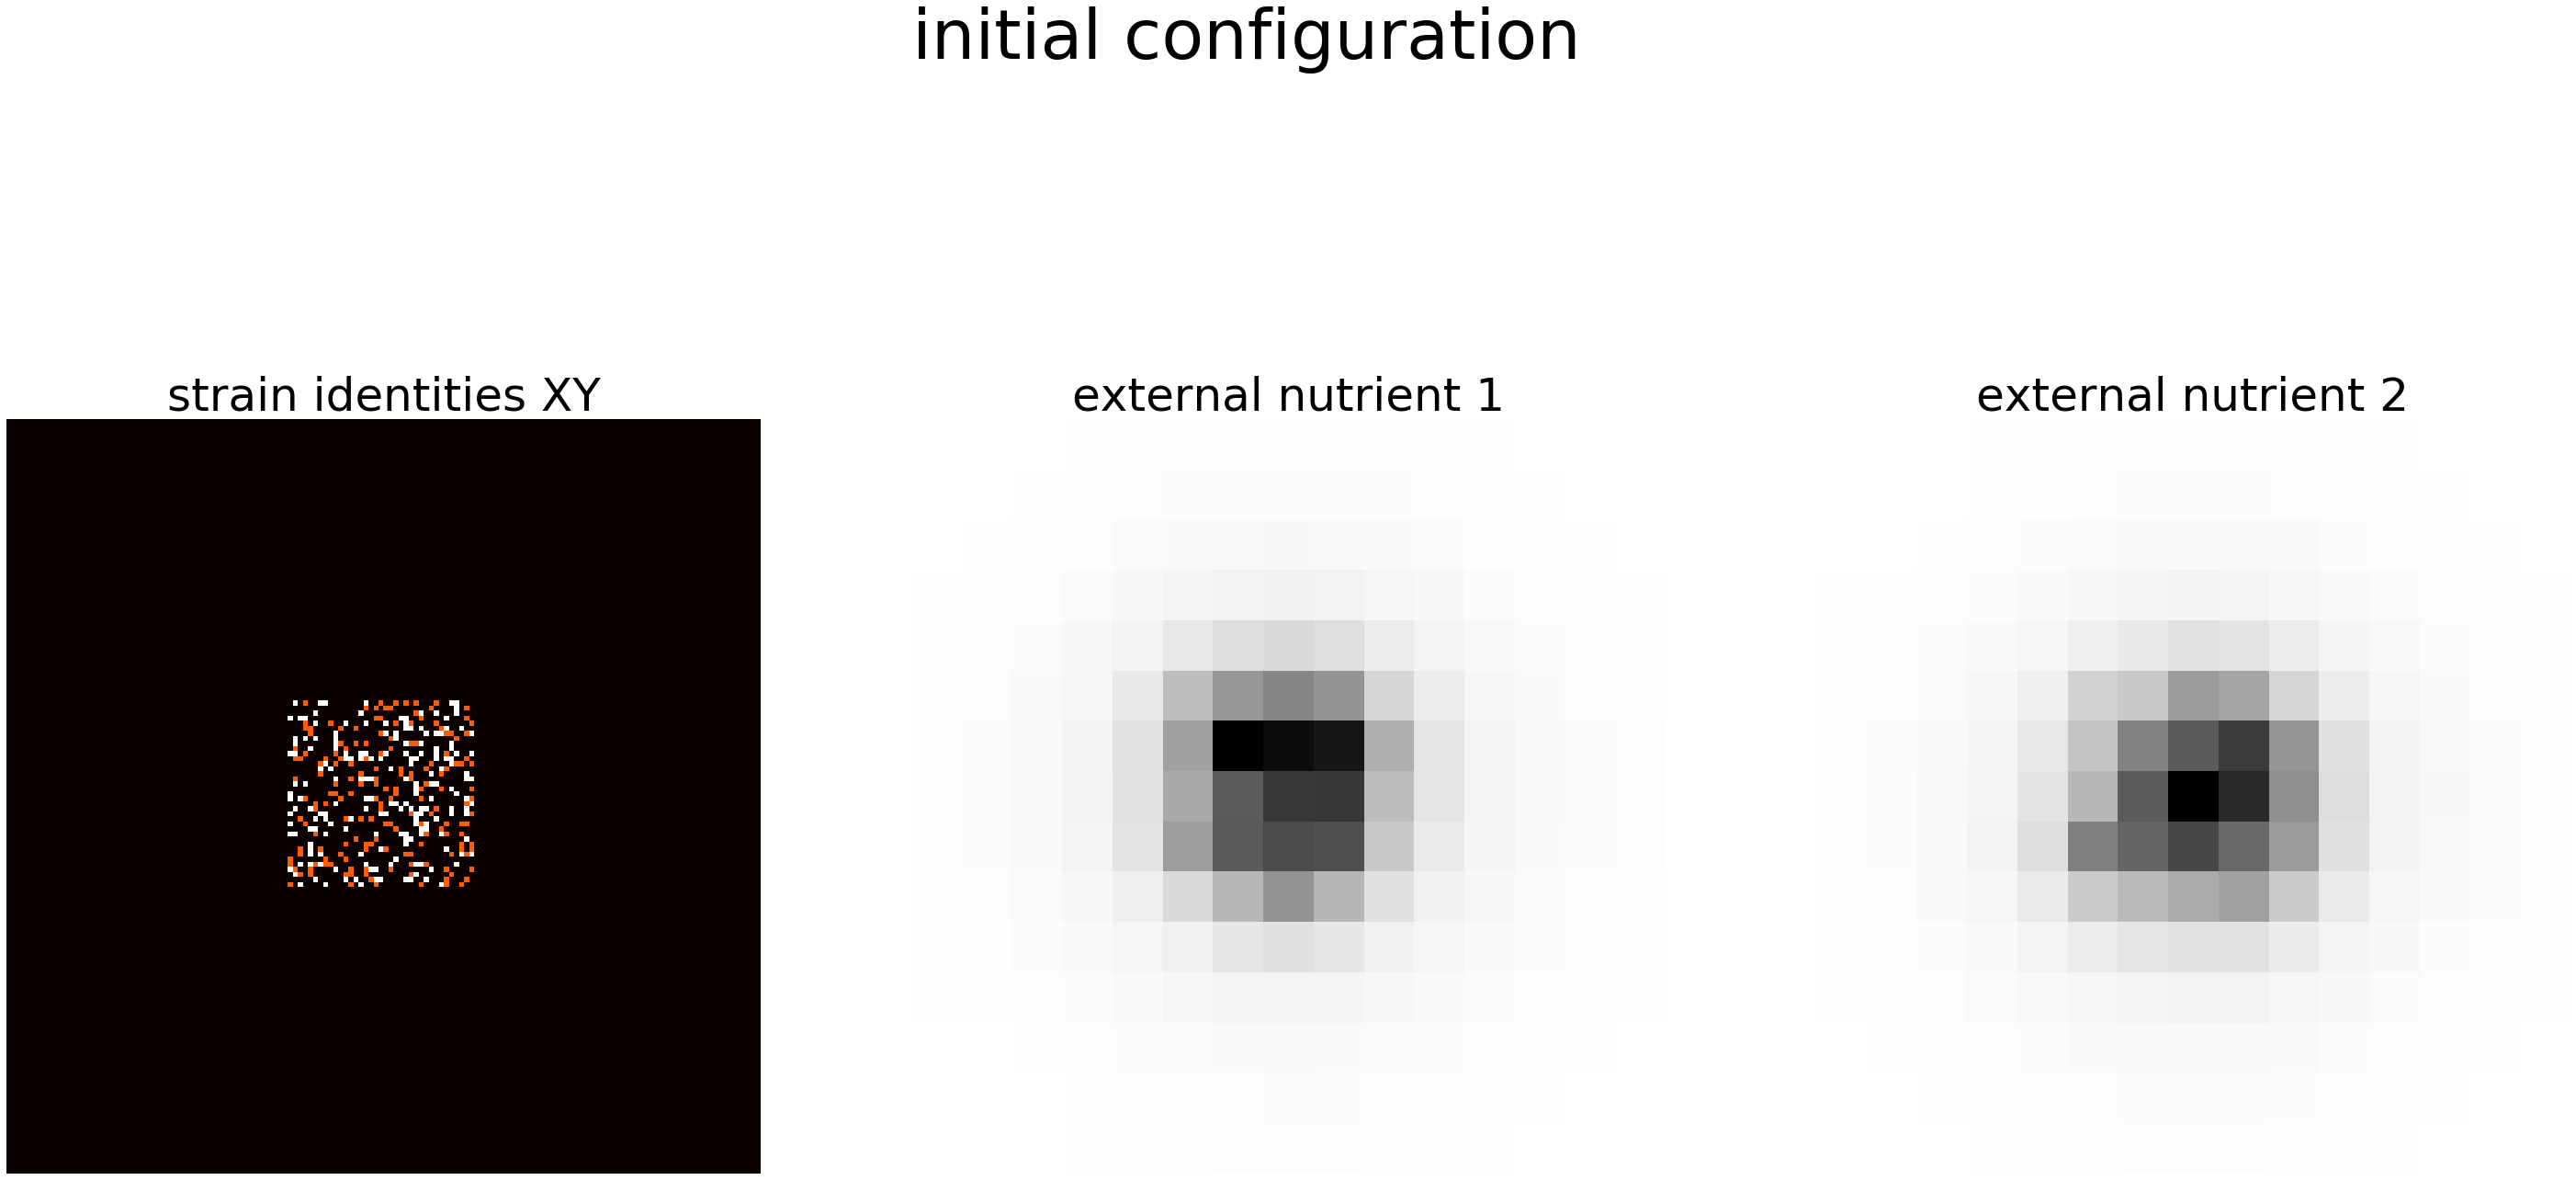

<ipython-input-24-e526650d8c40>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "iterate_life_and_death" failed type inference due to: Untyped global name 'get_bud_location': cannot determine Numba type of <class 'function'>

File "<ipython-input-24-e526650d8c40>", line 67:
def iterate_life_and_death(cells,dt,alphas,X):
    <source elided>
        if budded:
            bud_coords = get_bud_location(cell,X)
            ^

  @jit(parallel=True)
<ipython-input-24-e526650d8c40>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "iterate_life_and_death" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-24-e526650d8c40>", line 9:
def iterate_life_and_death(cells,dt,alphas,X):
    <source elided>
    
    for idx in prange(n_cells):
    ^

  @jit(parallel=True)
/Users/stevenredford/opt/anaconda3/lib/python3.7/site

In [ ]:
#initialize
cells,X = initialize_population(side_len,cell_size,n_strains,density,n_nutrients,dependencies,alphas,d,X)

#save_data(X,S,time,dt_cell,filepath)

#main loop
begin_time = tm.time()
draw_config_conc(X,S,n_nutrients,'initial configuration')
for tt in range(nsteps):
    
    for jj in range(dt_cell_to_diff_ratio):
        for nn in range(n_nutrients):
                S[nn,:,:,:] = update_nutrient(S[nn,:,:,:],DS,nn,cells,X,dt_diff,vm_list,km_list,gamma_list)
    
    new_cells,X_upd = iterate_life_and_death(cells,dt_cell,alphas,X)
    
    cells.extend(new_cells)
    X = X + X_upd
    
    if tt%10==0:
        draw_config_conc(X,S,n_nutrients,'configuration t = %s'%int(time[tt]/dt_cell))
    
    if time[tt]%10==0: #take 1 hour timepoints
        print('time = %s'%int(time[tt]*dt_cell),' hours')
        save_data(X,S,time,dt_cell,filepath)
    
end_time = tm.time()

print('one %s'%t_final + ' hour simulation took %s'%(end_time-begin_time))
    
print('Done! :D')
